# Imports & Downloads

In [16]:
import nltk
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from nltk.metrics import jaccard_distance
import re

import spacy
from spacy import displacy
import en_core_web_sm #model that will be used
nlp = en_core_web_sm.load()

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ne_chunk

In [2]:
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
!pip install svgling

     |████████████████████████████████| 66 kB 2.9 MB/s 


In [4]:
import svgling

In [5]:
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

%matplotlib inline

### INSTALL GHOSTSCRIPT (Required to display NLTK trees) ###
!apt install ghostscript python3-tk

from IPython.display import display

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (971 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following additional packages will be installed:
  fonts-droid-fa

# Setting Paths and other settings

In [6]:
PATH_INPUT = '/content/drive/MyDrive/Notebooks/IHLT/Labs/test-gold/STS.input.SMTeuroparl.txt'
PATH_GS = '/content/drive/MyDrive/Notebooks/IHLT/Labs/test-gold/STS.gs.SMTeuroparl.txt'
OUT_PATH = '/content/drive/MyDrive/Notebooks/IHLT/Labs/'

In [7]:
# suppress pandas copy error message
pd.options.mode.chained_assignment = None

In [8]:
from google.colab import drive
drive.mount('/content/drive',)

Mounted at /content/drive


# Loading Datasets

In [17]:
#Load dataset --> Done 
# Pos_tag them --> Done 
# Chunk them --> Done // only few sentences have a category corresponding to NE's
# compare Jaccard Distance --> Done
# & Golden Standard --> 

In [94]:
#Loading the dataset
dent = pd.read_csv(PATH_INPUT,sep='\t',header=None)
dent = dent.rename(columns={0: 'ENT_A', 1: 'ENT_B'})

# Functions

In [95]:
# dictionary of all the NEC in the sentences
def get_NEC_dict(df_column):
  d = dict()
  for idxA, xA in enumerate(df_column): 
    sent = nlp(xA)
    for s in sent.ents:
      d[s.text] = s.label_
  return d

# replacing the words with their corresponding NEC
# regex + previously made dictionary
def get_NEC_REPL_sent(df_column, DICT):
  l=[]
  for sent in df_column:
    rep = dict((re.escape(k), v) for k, v in DICT.items()) 
    pattern = re.compile("|".join(rep.keys()))
    textf = pattern.sub(lambda m: rep[re.escape(m.group(0))], sent)
    l.append(textf)
  return l

#jaccard distance for wanted cols
def get_jd(data_f, colA, colB,name):
  data_f[name] = ""
  for index in data_f.index:
    data_f[name][index] = 1 - jaccard_distance(set(data_f[colA][index]), set(data_f[colB][index]))
  return data_f

def sent_word_set(df, col):
  df[col+"_tok"] = df[col].apply(lambda x: nltk.sent_tokenize(x))
  df[col+"_tok"] = df[col+"_tok"].apply(lambda x: nltk.word_tokenize(x[0]))
  df[col+"_tok"] = df[col+"_tok"].apply(set)

  return df

# Processing Data

In [98]:
# Mapping the NEC to their words 
ent_a_dict = get_NEC_dict(dent['ENT_A'])
ent_b_dict = get_NEC_dict(dent['ENT_B'])

# Applying the replacement
dent['ENT_A_REPL'] = get_NEC_REPL_sent(dent['ENT_A'],ent_a_dict)
dent['ENT_B_REPL'] = get_NEC_REPL_sent(dent['ENT_B'],ent_b_dict)

#sent / word tokenizing and making a set (FOR THE REPLACED SENTENCES)
dent = sent_word_set(dent,'ENT_A_REPL')
dent = sent_word_set(dent,'ENT_B_REPL')

# same as above but for the original sentences 
dent = sent_word_set(dent,'ENT_A')
dent = sent_word_set(dent,'ENT_B')

# jaccard distance between the original sentence and the replaced sentence 
dent = get_jd(dent, 'ENT_A_tok','ENT_A_REPL_tok','JD_A_REPL')
dent = get_jd(dent, 'ENT_B_tok','ENT_B_REPL_tok','JD_B_REPL')


#jaccard sitance between NEC replaced sentences
dent = get_jd(dent, 'ENT_A_REPL_tok','ENT_B_REPL_tok','JD_ORIG_REPL')

#adding the Golden Standard
dent['gs'] = pd.read_csv(PATH_GS,sep='\t',header=None)

# Pearson Value

In [146]:
# pearson with: NEC being replaced in the original sentence and Sent tokenize + Word tokenize
round(pearsonr(dent['gs'], dent['JD_ORIG_REPL'])[0],2)

0.33

# Graphical Comparisson of Jaccard Distances

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


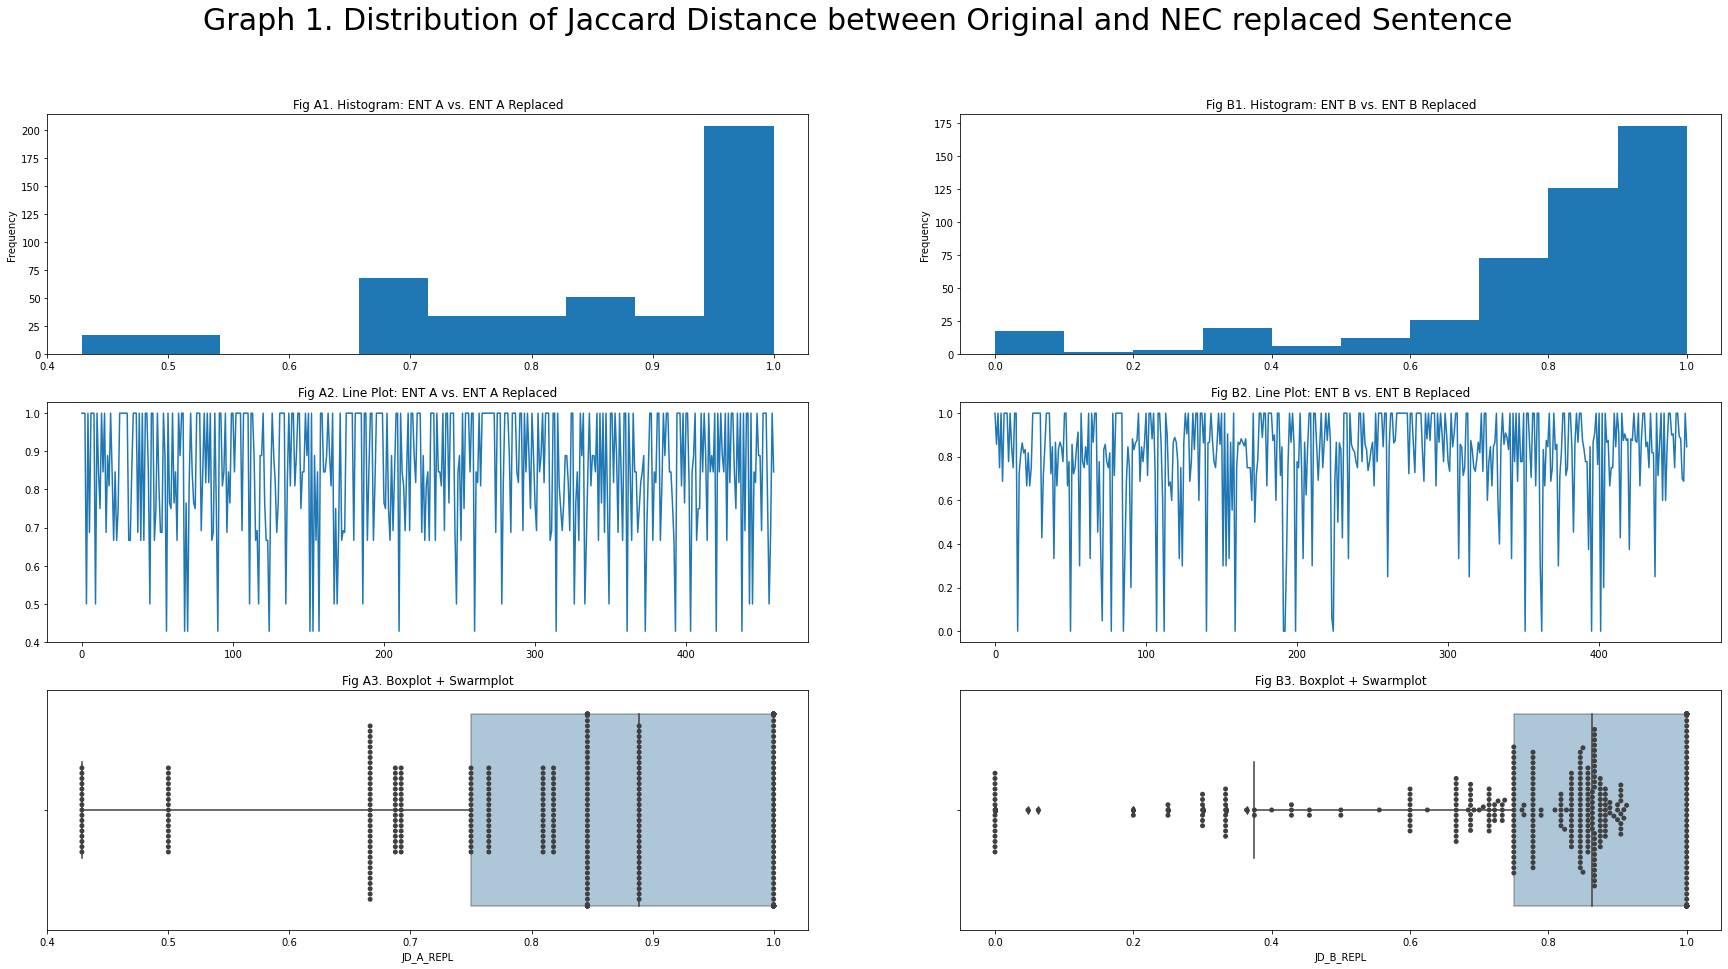

In [167]:
#isolating the desired columns 
new_df = dent[['JD_A_REPL','JD_B_REPL']]
# making plots
fig , axs = plt.subplots(3,2,figsize=(30,15))
plt.suptitle('Graph 1. Distribution of Jaccard Distance between Original and NEC replaced Sentence',size=30)
#histograms
axs[0,0] = dent['JD_A_REPL'].plot(kind='hist',ax=axs[0,0],title='Fig A1. Histogram: ENT A vs. ENT A Replaced')
axs[0,1] = dent['JD_B_REPL'].plot(kind='hist',ax=axs[0,1], title='Fig B1. Histogram: ENT B vs. ENT B Replaced')
#lineplots
axs[1,0] = dent['JD_A_REPL'].plot(ax=axs[1,0],title='Fig A2. Line Plot: ENT A vs. ENT A Replaced')
axs[1,1] = dent['JD_B_REPL'].plot(ax=axs[1,1], title='Fig B2. Line Plot: ENT B vs. ENT B Replaced')
#boxplot
axs[2,0] = sns.boxplot(x ='JD_A_REPL',data=new_df, orient="h",boxprops=dict(alpha=0.4),ax=axs[2,0])
axs[2,1] = sns.boxplot(x ='JD_B_REPL',data=new_df, orient="h",boxprops=dict(alpha=0.4),ax=axs[2,1])
# swarmplots
axs[2,0] = sns.swarmplot(x = 'JD_A_REPL',data=new_df,orient="h",s=5,color="0.25",ax=axs[2,0])
axs[2,1] = sns.swarmplot(x ='JD_B_REPL', data=new_df,orient="h",s=5,color="0.25",ax=axs[2,1])

axs[2,0].set_title('Fig A3. Boxplot + Swarmplot')
axs[2,1].set_title('Fig B3. Boxplot + Swarmplot')
plt.show()

# Report

1. **Design Decisions**

In this laboratory we are working with Named Entities. In this case, we are using SpaCy's named entity since it contains an English corpus, and it is simpler and well documented in comparisson to NLTK. Here we are going to do the following: 
 - Load the pairs of sentences
 - Identify the NEC
 - Replace the corresponding word with the NEC
 - Sentence & Word Tokenize 
 - Evaluate similarity using Jaccard Distance 

Initially, the approach was to directly compare the sentences without tokenizing but that resulted in very poor comparisson values (~ 0.032), which didn't make sense. Upon applying the tokenization (sentence and word) this increased by a factor of 10. After fixing that issue it was clear that NEC is an interesting way to compare sentences but it highly depends on the context of the corpus. More on this in the Conclusions section.

2. **Conclusions**

The result for the Jaccard Distance between the NEC replaced sentences is 0.33. Which comparing it to the previous laboratories is a new minimum (prior min was at 0.43 for similarity with Senses). Here it is important to note how the replacement of the NEC are being done. For example, initially, we made a dictionary and tried to replace the word, however, not all occurences of the word were replaced. This is why using RegEx, we were able to replace **all** instances of the corresponding NEC-Word pairs. 
For example a sentence which contained "Today at 5:30. PM" would then become "DATE at TIME". Now, comparing these sentences will result in low similarity because the "Today" and "5:30. PM" are 2/3 of the sentence already (taking 5:30. PM as a single token). In this case it makes sense that the similarity would decrease because it is now being calculated with 1/3 of the sentence.

Another interesting fact is to compare how the original sentence compares to the NEC replaced sentence. This is seen in Graph 1 above, with the respective subfigures (Fig A1-3, and Fig B1-3) corresponding to the original sentence pairs. We can see in the Boxplot + Swarmplot (Fig A3 + B3), we can see that the points are spread out quite significantly, proving the fact that NEC can change the similarity of the sentences. 

One last point to keep in mind is that the context of the corpus is important, for example in a setting where it talks more about Law (The defendant, the party, the organisation, etc..) could have a better comparisson than with other types. 

Overall, NEC is an interesting method to compare sentences but it would highly depend on the type of context the corpus comes from. As seen in this laboratory, and compared to the previous ones it would not be our first choice as the jaccard distances fluctuate too much between original sentence and NEC replaced sentence. 


